# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:cores-oracle.run1.limited",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "CORES_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
    ],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_20', 'ORACLE.run1_32', 'ORACLE.run1_44', 'ORACLE.run1_14', 'ORACLE.run1_26', 'ORACLE.run1_8', 'ORACLE.run1_50', 'ORACLE.run1_38'}


{'CORES_5', 'CORES_3', 'CORES_1', 'CORES_2', 'CORES_4'}


tensor([[[-1.8616e-03,  3.6622e-03,  4.8524e-03,  ...,  0.0000e+00,
          -1.6175e-03,  4.4252e-03],
         [-3.0519e-04, -1.3428e-03, -3.5401e-03,  ...,  3.9674e-04,
          -2.8687e-03,  1.4344e-03]],

        [[-2.1363e-03, -2.0753e-03,  6.8056e-03,  ...,  1.1292e-03,
           6.7141e-04, -2.9603e-03],
         [-4.2726e-04,  2.5330e-03, -2.1363e-03,  ...,  1.5870e-03,
           1.0071e-03,  1.8311e-04]],

        [[-8.2705e-03, -1.2207e-03,  3.8148e-03,  ...,  1.9837e-03,
          -3.2044e-03, -1.0071e-03],
         [ 1.8616e-03,  2.1973e-03, -4.1505e-03,  ...,  1.2818e-03,
           3.2960e-03, -4.5473e-03]],

        ...,

        [[-2.5025e-03, -2.2584e-03,  4.8219e-03,  ..., -5.7985e-04,
           3.5096e-03,  3.7843e-03],
         [ 2.8077e-03, -1.0071e-03,  6.1037e-04,  ..., -1.8006e-03,
           3.1739e-03,  3.3876e-03]],

        [[-2.7772e-03,  1.3428e-03, -9.1556e-05,  ..., -1.1292e-03,
          -3.3570e-04,  6.4089e-04],
         [-4.3031e-03, -2.9908e-0

In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 32.9540, train_label_loss: 2.7336, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3177.0683, train_label_loss: 1.6884, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3439.2884, train_label_loss: 1.0448, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3399.5113, train_label_loss: 1.2896, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3446.6224, train_label_loss: 1.1098, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3407.8121, train_label_loss: 1.0696, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3463.8858, train_label_loss: 1.2295, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3355.0115, train_label_loss: 1.2789, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3367.4294, train_label_loss: 1.0824, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3364.2384, train_label_loss: 0.8133, 


epoch: 1, source_val_acc_label: 0.5809, target_val_acc_label: 0.8533, source_val_label_loss: 3.1560, target_val_label_loss: 31.5153, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 3.3785, train_label_loss: 2.4439, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3892.6416, train_label_loss: 1.2353, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3892.9241, train_label_loss: 0.5834, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3915.0712, train_label_loss: 0.4922, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3949.3317, train_label_loss: 0.6911, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 4053.2899, train_label_loss: 0.8999, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3964.8488, train_label_loss: 0.8006, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3876.7713, train_label_loss: 0.8452, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 4043.3195, train_label_loss: 0.3178, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3131.1792, train_label_loss: 0.3489, 


epoch: 2, source_val_acc_label: 0.7541, target_val_acc_label: 0.9607, source_val_label_loss: 0.6850, target_val_label_loss: 2.1594, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.7837, train_label_loss: 0.3835, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2948.9817, train_label_loss: 0.9880, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 2969.7977, train_label_loss: 0.3732, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3005.3707, train_label_loss: 0.4803, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2954.5858, train_label_loss: 0.6382, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3004.7261, train_label_loss: 1.1069, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3066.9737, train_label_loss: 0.6085, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3389.1669, train_label_loss: 0.9017, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3384.5567, train_label_loss: 0.4773, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3256.3859, train_label_loss: 0.6137, 


epoch: 3, source_val_acc_label: 0.7942, target_val_acc_label: 0.9734, source_val_label_loss: 0.5953, target_val_label_loss: 2.3506, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.8263, train_label_loss: 1.0472, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3115.4654, train_label_loss: 0.2620, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3028.7318, train_label_loss: 0.3519, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2966.2334, train_label_loss: 0.2649, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2960.0613, train_label_loss: 0.3301, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2961.7662, train_label_loss: 0.2977, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3021.3062, train_label_loss: 0.1819, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3387.1126, train_label_loss: 0.1342, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3465.8373, train_label_loss: 0.4166, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3560.4324, train_label_loss: 0.6065, 


epoch: 4, source_val_acc_label: 0.8046, target_val_acc_label: 0.9851, source_val_label_loss: 0.5369, target_val_label_loss: 0.7854, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 3.2226, train_label_loss: 0.2465, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3365.3483, train_label_loss: 0.1992, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3553.1839, train_label_loss: 0.4800, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3538.8714, train_label_loss: 0.3534, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3933.9227, train_label_loss: 0.3441, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3468.5968, train_label_loss: 0.4522, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2986.9860, train_label_loss: 0.1854, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3188.6687, train_label_loss: 0.6879, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3365.0745, train_label_loss: 0.3526, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3626.9160, train_label_loss: 0.4088, 


epoch: 5, source_val_acc_label: 0.8111, target_val_acc_label: 0.9866, source_val_label_loss: 0.5392, target_val_label_loss: 0.8709, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.8158, train_label_loss: 0.1146, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2955.3878, train_label_loss: 0.5291, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2972.4300, train_label_loss: 0.4692, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2980.7545, train_label_loss: 0.1478, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2974.8866, train_label_loss: 0.4305, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2974.7427, train_label_loss: 0.1868, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2997.4918, train_label_loss: 0.1500, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3116.0999, train_label_loss: 0.3786, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3478.6168, train_label_loss: 0.1490, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3530.3654, train_label_loss: 0.3996, 


epoch: 6, source_val_acc_label: 0.8146, target_val_acc_label: 0.9863, source_val_label_loss: 0.5708, target_val_label_loss: 1.4531, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.8708, train_label_loss: 0.1810, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3042.3989, train_label_loss: 0.1195, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3015.3388, train_label_loss: 0.2538, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2985.4037, train_label_loss: 0.3351, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2976.5198, train_label_loss: 0.2323, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2990.3926, train_label_loss: 0.1549, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2998.4864, train_label_loss: 0.2229, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3098.3411, train_label_loss: 0.2511, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3466.9740, train_label_loss: 0.1842, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3502.6462, train_label_loss: 0.1692, 


epoch: 7, source_val_acc_label: 0.8154, target_val_acc_label: 0.9883, source_val_label_loss: 0.5670, target_val_label_loss: 1.2359, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.9846, train_label_loss: 0.4666, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3046.0902, train_label_loss: 0.1084, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3004.3333, train_label_loss: 0.2176, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3024.3867, train_label_loss: 0.4726, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3001.0573, train_label_loss: 0.5272, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3006.2991, train_label_loss: 0.0282, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3014.3844, train_label_loss: 0.2603, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3021.0141, train_label_loss: 0.1836, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3306.4708, train_label_loss: 0.2122, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3457.5092, train_label_loss: 0.1934, 


epoch: 8, source_val_acc_label: 0.8128, target_val_acc_label: 0.9885, source_val_label_loss: 0.5868, target_val_label_loss: 1.1596, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 3.2542, train_label_loss: 0.2558, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3496.2496, train_label_loss: 0.1098, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3449.0166, train_label_loss: 0.3510, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3435.6953, train_label_loss: 0.0690, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3336.6917, train_label_loss: 0.1848, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3493.4866, train_label_loss: 0.4549, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3998.3333, train_label_loss: 0.1613, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 4200.8567, train_label_loss: 0.1903, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 4352.9207, train_label_loss: 0.2505, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 4609.2074, train_label_loss: 0.1172, 


epoch: 9, source_val_acc_label: 0.8163, target_val_acc_label: 0.9904, source_val_label_loss: 0.5892, target_val_label_loss: 1.1948, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 5.0082, train_label_loss: 0.1931, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 4112.0958, train_label_loss: 0.1006, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3968.2479, train_label_loss: 0.1976, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3995.7018, train_label_loss: 0.0917, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 4007.0829, train_label_loss: 0.0504, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 4078.5040, train_label_loss: 0.2055, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3830.8718, train_label_loss: 0.3072, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3308.1060, train_label_loss: 0.0974, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2974.8309, train_label_loss: 0.0581, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2992.2412, train_label_loss: 0.2780, 


epoch: 10, source_val_acc_label: 0.8125, target_val_acc_label: 0.9895, source_val_label_loss: 0.6173, target_val_label_loss: 1.2316, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.8141, train_label_loss: 0.2692, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2992.2646, train_label_loss: 0.0427, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2987.8693, train_label_loss: 0.1009, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2970.3729, train_label_loss: 0.0497, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2943.0189, train_label_loss: 0.1312, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3376.7378, train_label_loss: 0.0296, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3402.7998, train_label_loss: 0.1471, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3312.4708, train_label_loss: 0.2298, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2989.6465, train_label_loss: 0.0346, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2981.6475, train_label_loss: 0.0530, 


epoch: 11, source_val_acc_label: 0.8126, target_val_acc_label: 0.9890, source_val_label_loss: 0.6463, target_val_label_loss: 1.4417, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.8440, train_label_loss: 0.0925, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2997.7795, train_label_loss: 0.1617, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3016.5279, train_label_loss: 0.0821, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3013.9474, train_label_loss: 0.3613, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3026.9410, train_label_loss: 0.0477, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3423.0486, train_label_loss: 0.1568, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3470.3335, train_label_loss: 0.0605, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3535.2664, train_label_loss: 0.0975, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3049.2357, train_label_loss: 0.1839, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3062.1599, train_label_loss: 0.0966, 


epoch: 12, source_val_acc_label: 0.8079, target_val_acc_label: 0.9875, source_val_label_loss: 0.6707, target_val_label_loss: 1.9279, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.8278, train_label_loss: 0.1374, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3030.1701, train_label_loss: 0.0800, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2967.1957, train_label_loss: 0.0603, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2962.2181, train_label_loss: 0.1037, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2980.5489, train_label_loss: 0.0853, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3304.5146, train_label_loss: 0.0945, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3432.2314, train_label_loss: 0.0438, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3446.2294, train_label_loss: 0.2787, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2986.7505, train_label_loss: 0.0599, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2955.6064, train_label_loss: 0.0866, 


epoch: 13, source_val_acc_label: 0.8057, target_val_acc_label: 0.9901, source_val_label_loss: 0.6974, target_val_label_loss: 1.2253, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

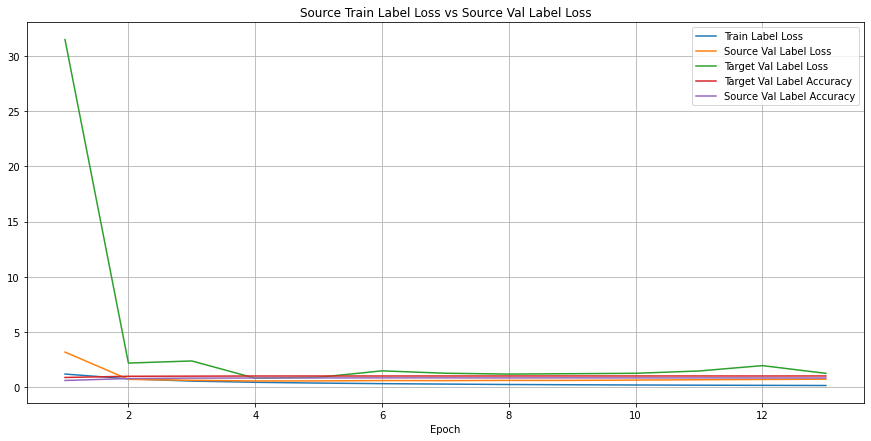

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

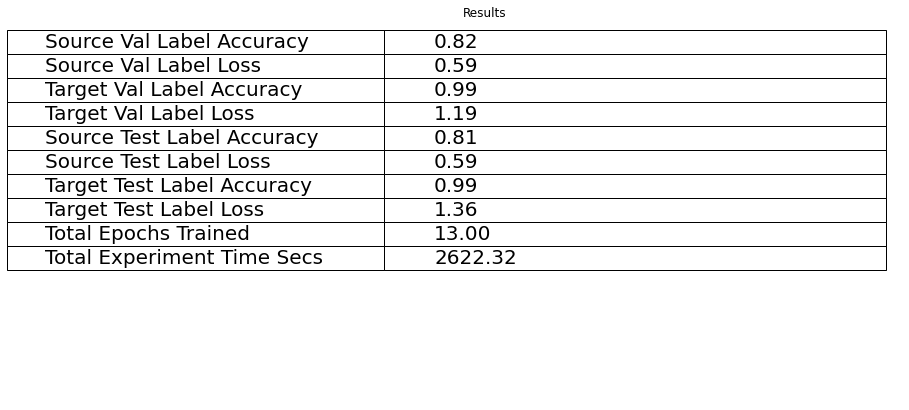

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

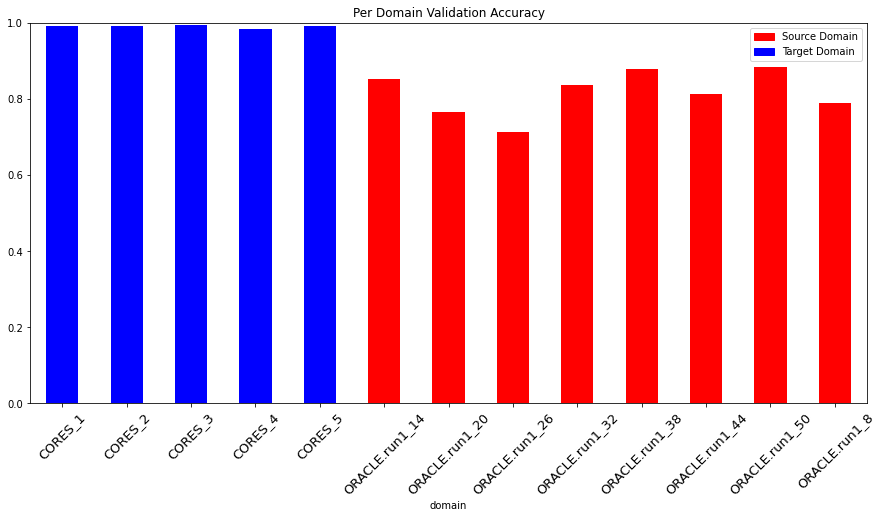

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.8134440104166667 Target Test Label Accuracy: 0.9882415254237288
Source Val Label Accuracy: 0.8163411458333333 Target Val Label Accuracy: 0.9903928571428572


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:cores-oracle.run1.limited", "parameters": {"experiment_name": "tl_1v2:cores-oracle.run1.limited", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}